In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons
import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.activations import swish
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import (
    Layer, 
    Input, 
    Conv2D, 
    BatchNormalization, 
    Lambda, 
    Concatenate,
    SeparableConv2D, 
    MaxPooling2D, 
    UpSampling2D, 
    Conv2DTranspose,
    SpatialDropout2D, 
    ReLU, 
    GlobalAveragePooling2D, 
    Add,
    GlobalMaxPooling2D, 
    Dense, 
    Reshape, 
    Multiply, 
    Activation
)
from tensorflow.keras import backend as K

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-sqv94f0p
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-sqv94f0p
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440305 sha256=862f7580e2acf1296ce0e6ae75b0ea91f2e4e2829d571fa9659670c3af04e472
  Stored in directory: /tmp/pip-ephem-wheel-cache-ejzrluc4/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfull

2025-10-18 10:42:18.187239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760784138.397118      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760784138.460804      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
working_dir = '/kaggle/working'
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")

❌ xóa thành công /kaggle/working/.virtual_documents


In [ ]:
def get_bounding_box(mask, padding=15):
    if len(mask.shape) < 2 or len(mask.shape) > 3:
        raise ValueError("Mask phải là 2D hoặc 3D (grayscale).")


    mask = (mask > 0).astype(np.uint8)

    coords = np.argwhere(mask > 0)
    
    if coords.size == 0:
        return None  

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    dynamic_padding = max(padding, min((x_max - x_min) // 10, (y_max - y_min) // 10))

    h, w = mask.shape[:2]
    x_min = max(0, x_min - dynamic_padding)
    y_min = max(0, y_min - dynamic_padding)
    x_max = min(w, x_max + dynamic_padding)
    y_max = min(h, y_max + dynamic_padding)

    return x_min, y_min, x_max, y_max

In [ ]:
def preprocess_image_no_clahe(img, mask, img_size=(256, 256)):
    bbox = get_bounding_box(mask, padding=15)

    if bbox is None:     
        cropped_img_rgb = img 
        cropped_mask = mask
    else:
        x_min, y_min, x_max, y_max = bbox
           
        cropped_img_rgb = img[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]
    
    img_resized = cv2.resize(cropped_img_rgb, img_size, interpolation=cv2.INTER_LINEAR)
    
    mask_resized = cv2.resize(cropped_mask, img_size, interpolation=cv2.INTER_NEAREST)
    
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

    img_normalized = img_gray.astype(np.float32) / 255.0
    
    mask_normalized = (mask_resized > 127).astype(np.float32)

    return img_normalized, mask_normalized

In [ ]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))

    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []


    csv_data = pd.read_csv(csv_file)
    mel_label_series = csv_data.set_index('image_id')['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu (Cropping + Resize + Grayscale + MinMax)...")
    for img_path in tqdm(image_files):
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        if not os.path.exists(mask_file) or not os.path.exists(binary_file) or img_id not in mel_label_series.index:
            continue

        try:  
            img_original = cv2.imread(img_path)
            img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

            mask_original = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            img_final, mask_final = preprocess_image_no_clahe(img_original, mask_original, img_size)


            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)
            label = mel_label_series.loc[img_id]
            images.append(img_final)
            masks.append(mask_final)
            image_ids.append(img_id)
            labels.append(label)

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    images = np.array(images)[..., np.newaxis] 
    masks = np.array(masks)[..., np.newaxis]   
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape} (Ảnh Grayscale 1 kênh, MinMax [0, 1])")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")
    
    return images, masks, binary_masks, image_ids, labels

In [6]:
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Train_Data',
    mask_path='/kaggle/input/isic-2750/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Train_GroundTruth_2',
    csv_file="/kaggle/input/2075-csv/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu (Cropping + Resize + Grayscale + MinMax)...


100%|██████████| 1925/1925 [07:50<00:00,  4.09it/s]



Đã đọc thành công 1925 ảnh
Shape của images: (1925, 256, 256, 1) (Ảnh Grayscale 1 kênh, MinMax [0, 1])
Shape của masks: (1925, 256, 256, 1)
Shape của labels: (1925,)


In [7]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Test_Data',
    mask_path='/kaggle/input/isic-2750/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Test_GroundTruth_2',
    csv_file='/kaggle/input/2075-csv/Test_GroundTruth_3 (1).csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu (Cropping + Resize + Grayscale + MinMax)...


100%|██████████| 825/825 [03:21<00:00,  4.09it/s]


Đã đọc thành công 825 ảnh
Shape của images: (825, 256, 256, 1) (Ảnh Grayscale 1 kênh, MinMax [0, 1])
Shape của masks: (825, 256, 256, 1)
Shape của labels: (825,)


In [ ]:
def convert_to_gray_clahe(images_normalized):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    images_clahe_processed = []

    for img in images_normalized:
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)

        img_uint8 = (img * 255).astype(np.uint8)

        img_clahe_uint8 = clahe.apply(img_uint8)
        
        img_clahe_normalized = img_clahe_uint8.astype(np.float32) / 255.0
        
        images_clahe_processed.append(img_clahe_normalized)

    return np.array(images_clahe_processed)[..., np.newaxis] 


train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

print(f"Shape ảnh huấn luyện sau CLAHE: {train_images_gray_clahe.shape}")

Shape ảnh huấn luyện sau CLAHE: (1925, 256, 256, 1)


In [ ]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou
    
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    jaccard_coeff = (intersection + smooth) / (union + smooth)
    return 1.0 - jaccard_coeff

def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [ ]:
def cbam_module(input_features, reduction_ratio=8):

    filters = input_features.shape[-1]    
    
    avg_pool = GlobalAveragePooling2D()(input_features)
    max_pool = GlobalMaxPooling2D()(input_features)
    
    shared_dense_1 = Dense(filters // reduction_ratio, 
                           activation='relu', 
                           kernel_initializer='he_normal', 
                           use_bias=True)
    
    shared_dense_2 = Dense(filters, 
                           use_bias=True)
    
    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))
    
    channel_sum = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_sum)
    channel_attention = Reshape((1, 1, filters))(channel_attention)
    channel_refined = Multiply()([input_features, channel_attention])
   
    avg_spatial = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True), 
                         output_shape=lambda s: (s[0], s[1], s[2], 1))(channel_refined)
    max_spatial = Lambda(lambda x: K.max(x, axis=-1, keepdims=True), 
                         output_shape=lambda s: (s[0], s[1], s[2], 1))(channel_refined)

    spatial_concat = Concatenate(axis=-1)([avg_spatial, max_spatial])
    
    spatial_attention = Conv2D(1, 
                               (7, 7), 
                               padding='same', 
                               activation='sigmoid', 
                               use_bias=False)(spatial_concat)
    
    refined_features = Multiply()([channel_refined, spatial_attention])
    
    
    return refined_features

In [ ]:
def simam(x, lambda_val=1e-4):  
    shape = tf.shape(x)
    H, W = shape[1], shape[2]
    n = tf.cast(H * W - 1, x.dtype)
    
    mu = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    d = tf.square(x - mu)
    var = tf.reduce_sum(d, axis=[1, 2], keepdims=True) / n
    e_t = d / (4 * (var + lambda_val)) + 0.5
    
    return x * tf.nn.sigmoid(e_t)

def aspp_module(input_tensor, output_filters=1024, rates=[1, 6, 12, 18]):
    num_branches = len(rates)
    branch_filters = output_filters // num_branches

    branches = []
    for rate in rates:
        branch = SeparableConv2D(branch_filters, (3, 3), padding='same', dilation_rate=rate, use_bias=False,
                                  depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(input_tensor)
        branch = BatchNormalization()(branch)
        branch = ReLU()(branch)
        branches.append(branch)

    concatenated = Concatenate()(branches)
    attended = Lambda(simam)(concatenated)

    final_conv = SeparableConv2D(output_filters, (1, 1), padding='same', use_bias=False,
                                  depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(attended)
    final_conv = BatchNormalization()(final_conv)
    final_conv = ReLU()(final_conv)
    final_conv = SpatialDropout2D(0.2)(final_conv)
    return final_conv

In [ ]:
def CustomSegUNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(inputs)
    c1 = BatchNormalization()(c1); c1 = ReLU()(c1)
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c1)
    c1 = BatchNormalization()(c1); c1 = ReLU()(c1)
    c1 = SpatialDropout2D(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p1)
    c2 = BatchNormalization()(c2); c2 = ReLU()(c2)
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c2)
    c2 = BatchNormalization()(c2); c2 = ReLU()(c2)
    c2 = SpatialDropout2D(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

 
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p2)
    c3 = BatchNormalization()(c3); c3 = ReLU()(c3)
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c3)
    c3 = BatchNormalization()(c3); c3 = ReLU()(c3)
    c3 = SpatialDropout2D(0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)


    c4 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p3)
    c4 = BatchNormalization()(c4); c4 = ReLU()(c4)
    c4 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c4)
    c4 = BatchNormalization()(c4); c4 = ReLU()(c4)
    c4 = SpatialDropout2D(0.1)(c4)
    p4 = MaxPooling2D((2, 2))(c4)


    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p4)
    c5 = BatchNormalization()(c5); c5 = ReLU()(c5)
    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c5)
    c5 = BatchNormalization()(c5); c5 = ReLU()(c5)
    c5 = SpatialDropout2D(0.1)(c5)
    p5 = MaxPooling2D((2, 2))(c5)
    
    c6 = aspp_module(p5, output_filters=1024, rates=[1, 6, 12, 18])

    u7 = Conv2DTranspose(512, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c6)
    u7 = Concatenate()([u7, c5])
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u7)
    c7 = BatchNormalization()(c7); c7 = ReLU()(c7)
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c7)
    c7 = BatchNormalization()(c7); c7 = ReLU()(c7)
    c7 = cbam_module(c7)

    u8 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c7)
    u8 = Concatenate()([u8, c4])
    c8 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u8)
    c8 = BatchNormalization()(c8); c8 = ReLU()(c8)
    c8 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c8)
    c8 = BatchNormalization()(c8); c8 = ReLU()(c8)
    c8 = cbam_module(c8)

    u9 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c8)
    u9 = Concatenate()([u9, c3])
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u9)
    c9 = BatchNormalization()(c9); c9 = ReLU()(c9)
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c9)
    c9 = BatchNormalization()(c9); c9 = ReLU()(c9)
    c9 = cbam_module(c9)

    u10 = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c9)
    u10 = Concatenate()([u10, c2])
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u10)
    c10 = BatchNormalization()(c10); c10 = ReLU()(c10)
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c10)
    c10 = BatchNormalization()(c10); c10 = ReLU()(c10)
    c10 = cbam_module(c10)

    u11 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c10)
    u11 = Concatenate()([u11, c1])
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u11)
    c11 = BatchNormalization()(c11); c11 = ReLU()(c11)
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c11)
    c11 = BatchNormalization()(c11); c11 = ReLU()(c11)
    c11 = cbam_module(c11)

 
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

    return Model(inputs=inputs, outputs=outputs)

if __name__ == "__main__":
    model = CustomSegUNet()
    model.summary()

I0000 00:00:1760784825.786478      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 256, 256, 64)   │            137 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 256, 256, 64)   │          4,736 │ re_lu[0][0]            │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 256, 256, 64)   │              0 │ re_lu_1[0][0]          │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ spatial_dropout2d[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 128, 128, 128)  │          8,896 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ separable_conv2d_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 128, 128, 128)  │         17,664 │ re_lu_2[0][0]          │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ separable_conv2d_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)       

 Total params: 10,530,636 (40.17 MB)

 Trainable params: 10,516,812 (40.12 MB)

 Non-trainable params: 13,824 (54.00 KB)

In [13]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [ ]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

segunet = CustomSegUNet(input_size=(256, 256, 1))
segunet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)
model_checkpoint_dir = 'model'
checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'gray2750.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)
start_time = time.time()

history = segunet.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time

avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

print("SegUNet output shape:", segunet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100


I0000 00:00:1760784866.355143     192 service.cc:148] XLA service 0x7cf5c007c340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760784866.358004     192 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760784869.824482     192 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1760784893.332824     192 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760784893.558598     192 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760784895.467431     192 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760784895.6789

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.7653 - jaccard_coefficient: 0.5498 - loss: 0.3037

E0000 00:00:1760784971.790303     192 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760784972.023372     192 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760784973.247763     192 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760784973.480641     192 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760784976.355085     192 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7667 - jaccard_coefficient: 0.5522 - loss: 0.3019   
Epoch 1: loss improved from inf to 0.19443, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.7681 - jaccard_coefficient: 0.5544 - loss: 0.3001 - learning_rate: 0.0010
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.9239 - jaccard_coefficient: 0.8520 - loss: 0.0800
Epoch 2: loss improved from 0.19443 to 0.07727, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 45s 741ms/step - accuracy: 0.9239 - jaccard_coefficient: 0.8520 - loss: 0.0800 - learning_rate: 0.0010
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.9250 - jaccard_coefficient: 0.8648 - loss: 0.0726
Epoch 3: loss improved from 0.07727 to 0.06998, saving model to model/gray2750.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 45s 740ms/step - accuracy: 0.9251 - jaccard_coefficient: 0.8649 - loss: 0.0725 - learning_rate: 0.0010
Epoch 4

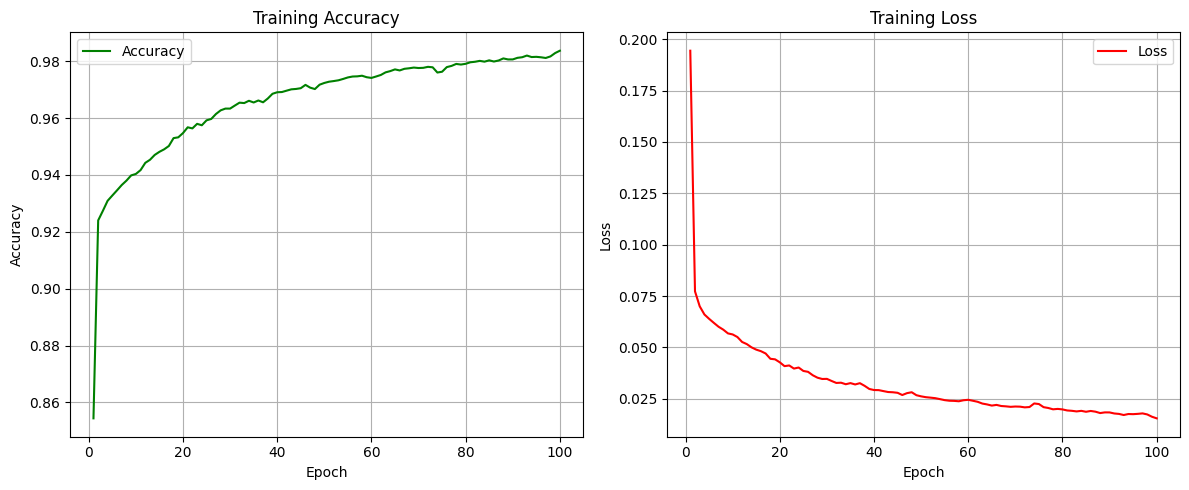

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('Gray_2750_acc_loss.png', dpi=300)
plt.show()


In [ ]:
results = segunet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")


predictions_before = segunet.predict(test_images_gray_clahe)
predictions_before_bin = (predictions_before > 0.5).astype(np.uint8)

y_true_flat = test_masks.flatten()
y_pred_flat_before = predictions_before_bin.flatten()

print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat_before, target_names=["Background", "Lesion"]))

precision_before = precision_score(y_true_flat, y_pred_flat_before)
recall_before = recall_score(y_true_flat, y_pred_flat_before)
f1_before = f1_score(y_true_flat, y_pred_flat_before)

print(f"Precision: {precision_before:.4f}")
print(f"Recall:    {recall_before:.4f}")
print(f"F1-score:  {f1_before:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9453 - jaccard_coefficient: 0.9021 - loss: 0.0517
Dice Loss: 0.0592, Accuracy: 93.72%, Jaccard: 88.87%
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step

Classification Report:
              precision    recall  f1-score   support

  Background       0.94      0.93      0.93  25513752
      Lesion       0.94      0.95      0.94  28553448

    accuracy                           0.94  54067200
   macro avg       0.94      0.94      0.94  54067200
weighted avg       0.94      0.94      0.94  54067200

Precision: 0.9362
Recall:    0.9454
F1-score:  0.9408


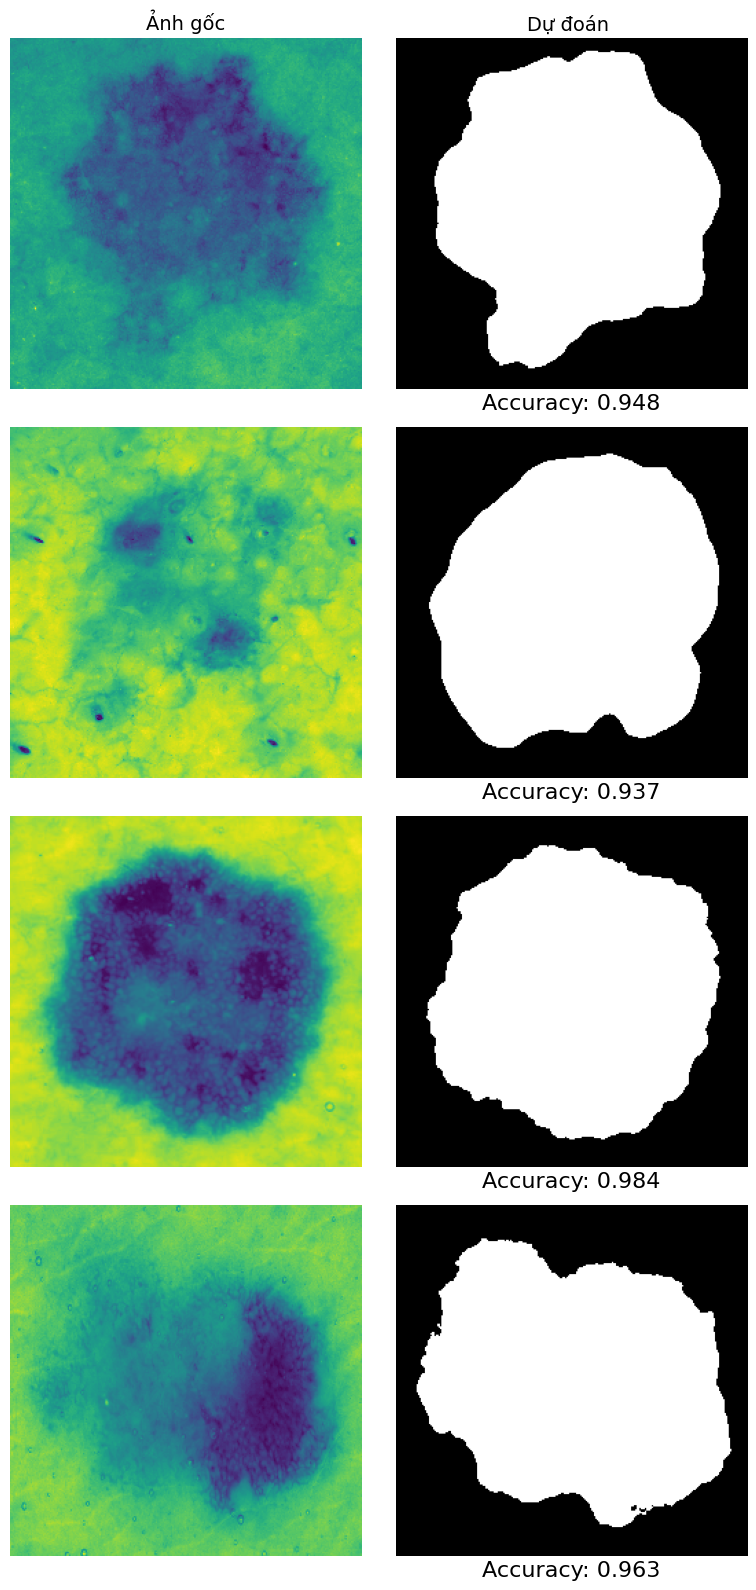

In [ ]:
def np_accuracy(y_true, y_pred):

    return accuracy_score(y_true.flatten(), y_pred.flatten())

def show_predictions_with_metrics_grid(predictions,  
                                         images, masks,
                                         indices,
                                         save_path):

    num_images = len(indices)
    plt.figure(figsize=(8, 4 * num_images))  

    for i, idx in enumerate(indices):
        image = images[idx]
        true_mask = masks[idx]
        pred_mask = predictions[idx] 

   
        if pred_mask.shape != true_mask.shape:
            pred_mask = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        accuracy = np_accuracy(true_mask, pred_mask)

        ax1 = plt.subplot(num_images, 2, 2*i + 1)
        ax1.imshow(image)
        ax1.axis('off')

        ax2 = plt.subplot(num_images, 2, 2*i + 2)
        ax2.imshow(pred_mask, cmap='gray')
        ax2.axis('off')
        

        if i == 0: 
             ax1.set_title(f"Ảnh gốc", fontsize=14)
             ax2.set_title(f"Dự đoán ", fontsize=14)
             
        ax2.text(0.5, -0.01,
                 f"Accuracy: {accuracy:.3f}",
                 fontsize=16, ha='center', va='top', transform=ax2.transAxes)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()



show_predictions_with_metrics_grid(
    predictions=predictions_before_bin,  
    images=test_images,
    masks=test_masks,
    indices=[722, 191, 54, 700], 
    save_path='results.png' 
)

In [19]:
segunet.save('/kaggle/working/model/2.0-gray_2750_model.h5')
segunet.save('/kaggle/working/model/2.0-gray_2750_model.keras')